In [26]:
# Install packages if needed with this command: 
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Packages used at own account
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score, recall_score, classification_report
import keras 
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu, softmax
from skimage.restoration import denoise_nl_means, estimate_sigma

# 1. Load dataset


In [18]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset', 
                                    path=data_dir, unzip=True)

In [19]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f: 
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f: 
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]), 
                                label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f: 
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]), 
                               label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f: 
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]), 
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# 2. Visualise data and plot data distribution

**Assignment 1:** There are 6 classes and that classes are represented as unique integers. Therefore as the assignment desribes, we can use a one hot encoding for the class element of each sample, transforming the integer into a 6 element binary vector with a 1 for the index of the class value. We can achieve this with the `to_categorical()` function. (Code Used from Practical 2)

In [20]:
## This changes the labels to seperate variable which is one hot encoded.
from tensorflow.keras.utils import to_categorical

# one-hot encode the integer labels
train_data_labels_one_hot = to_categorical(train_data.classes)
test_data_labels_one_hot = to_categorical(test_data.classes)
val_data_labels_one_hot = to_categorical(val_data.classes)


**Assignment 2**: Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image. Arrange these images and labels in a single figure, ensuring that they are visually clear and labeled properly

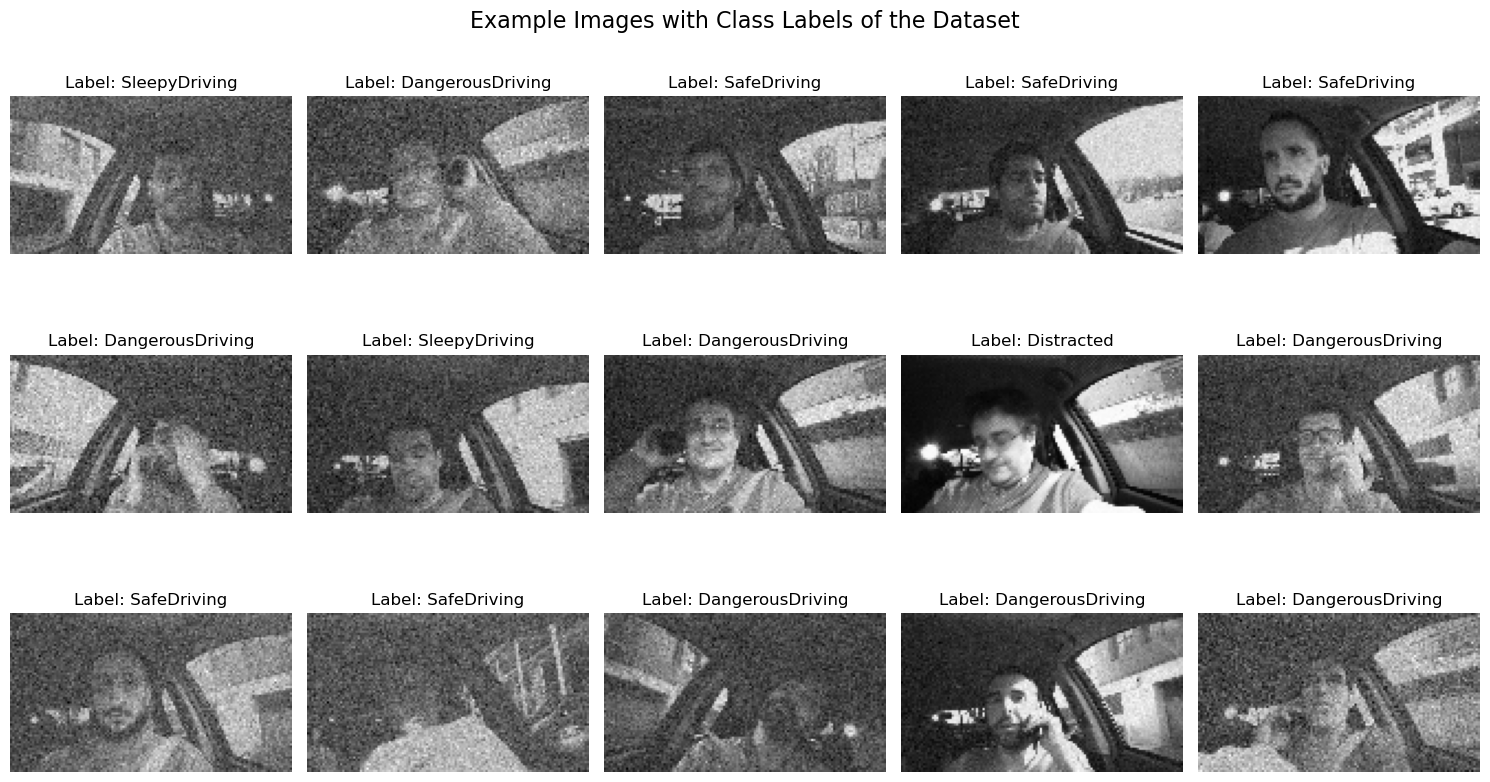

In [21]:
# Get images and labels from the training dataset (assignment is unambigious which dataset).
images, labels = next(train_data)
## Confused as this next function. already encodes the label one hot. Try to print yourself by uncommenting the line below
# print(labels)
# images.shape => (32, 72, 128, 1)  # batch_size=32, H=72, W=128, 1=grayscale (so there is only one channel)
# labels.shape => (32, 6)          # one-hot vectors for 6 classes

# Randomly select 15 samples
num_samples = 15
random_indices = np.random.choice(len(images), size=num_samples, replace=False)  # Randomly select indices without replacement
sampled_images, sampled_labels = images[random_indices], labels[random_indices] # Select samples

# Get class names from the training data in a list
class_names = list(train_data.class_indices.keys())

# Create a figure with a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle("Example Images with Class Labels of the Dataset", fontsize=16, y=0.95)
axes = axes.ravel()  # Flatten the axes for easy iteration

for ax, image, label_onehot in zip(axes, sampled_images, sampled_labels):
    # Convert grayscale image from (H, W, 1) to (H,W) in order to plot it
    grayscale_image = np.squeeze(image)
    
    # Decode on-hot label to class index and name
    label_index = np.argmax(label_onehot)  # Takes the index of the maximum value (the 1 in the 0-1 encoded values)
    label_name = class_names[label_index]  # Gives the correct name to the numerical value; this works because the images/labels are iterated at the same time, so this connection can be made. 
    
    # Display image with label 
    ax.imshow(grayscale_image, cmap='gray')
    ax.set_title(f"Label: {label_name}")
    ax.axis('off')
plt.tight_layout()


plt.show()

**Assignment 3**: Create a bar plot to visualize the class label distribution of the dataset. (Hint: this bar plot reveals how many samples the dataset has for each class)

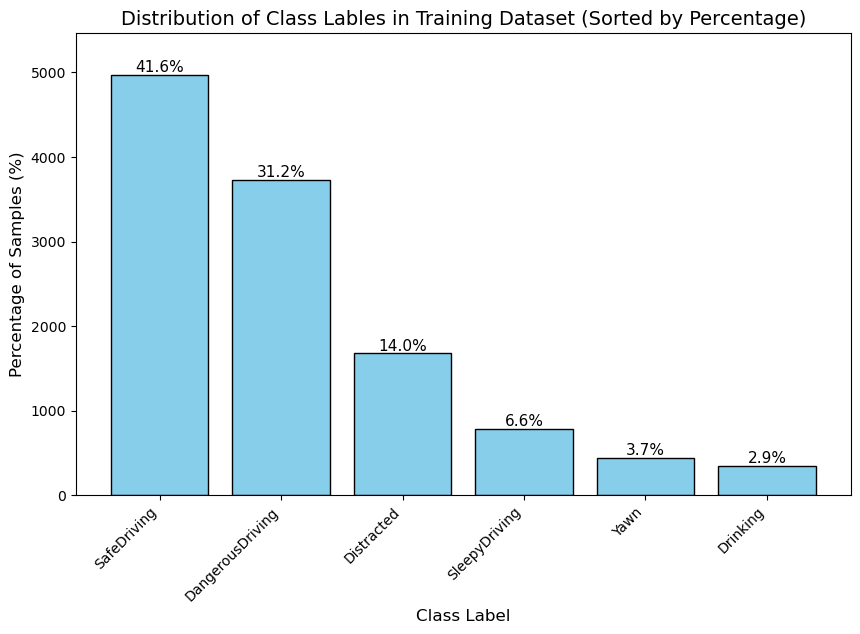

In [22]:
## As done in the previous section; extract class names, from training data
train_labels = train_data.classes
class_names = list(train_data.class_indices.keys())

# Create a pandas dataframe, to count the occurence of each class
## Reindex length to make sure the mapping is correct, without reindex label and counts are not correctly attached
## As than the index is created by the number of occurences so the class Safedriving with highest numerical value is now for class occurence labeld as 0
## This is prevented with reindex(range(len(class_names)))
# print(pd.Series(train_labels).value_counts()) ## Uncomment to look at the differences
class_counts = pd.Series(train_labels).value_counts().reindex(range(len(class_names)))
total_samples = sum(class_counts)
percentages = [(count / total_samples) * 100 for count in class_counts]

# Get indices of sorted percentages inorder to likewise sort class_names, class_counts, percentages
## This keeps the encoding properly
sorted_indices = np.argsort(percentages)[::-1]  
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_class_counts = [class_counts[i] for i in sorted_indices]
sorted_percentages = [percentages[i] for i in sorted_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_names, sorted_class_counts, color="skyblue", edgecolor="black")

# Annotate bars with percentages
for bar, percent in zip(bars, sorted_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom', fontsize=11, color='black')

# Labels and formatting
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Percentage of Samples (%)", fontsize=12)
plt.title("Distribution of Class Lables in Training Dataset (Sorted by Percentage)", fontsize=14)
plt.xticks(ticks=range(len(sorted_class_names)), labels=sorted_class_names, rotation=45, ha="right")
plt.ylim(0, max(sorted_class_counts) * 1.1)

# Show plot
plt.show()

## Data augmentation

In [23]:
# Collect images and labels from the existing iterator
def extract_data(data_iterator):
    images_list = []
    labels_list = []

    # Iterate through the entire dataset
    for i in range(len(data_iterator)):
        batch_images, batch_labels = data_iterator[i]
        images_list.append(batch_images)
        labels_list.append(batch_labels)

    # Stack the batches into NumPy arrays
    images_array = np.vstack(images_list)
    labels_array = np.vstack(labels_list)
    
    return images_array, labels_array

# Extract the images and labels
train_images, train_labels = extract_data(train_data)
val_images, val_labels = extract_data(val_data)
test_images, test_labels = extract_data(test_data)

print("Train set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, val_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)

def denoise(img):
    sigma_est = estimate_sigma(img)
    img = denoise_nl_means(img, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    return img

second_data_gen = ImageDataGenerator(preprocessing_function=denoise)  # Example: without noise or with different augmentation

train_data_aug = second_data_gen.flow(
    train_images, train_labels,
    batch_size=batch_size,
    shuffle=False  # You can control whether to shuffle here
)

val_data_aug = second_data_gen.flow(
    val_images, val_labels,
    batch_size=batch_size,
    shuffle=False
)

test_data_aug = second_data_gen.flow(
    test_images, test_labels,
    batch_size=batch_size,
    shuffle=False
)

Train set: (11948, 72, 128, 1) (11948, 6)
Validation set: (1922, 72, 128, 1) (1922, 6)
Test set: (985, 72, 128, 1) (985, 6)


# 3. Train and Evaluation functions

**Assignment 4**: Use the provided validation set to validate your chosen model hyperparameters. Implement the baseline CNN model (exactly, without any modification for both model and dataset) that is shown in Fig. 2. It is a network consisting of:
1. 3 successive blocks, each containing a 2D convolutional (kernel size 3×3; 8 output channels) and a max-pooling layer (window size 2 × 2),
2. a dense layer projecting a 784-dimensional space to 10 dimensions
3. a dense layer projecting a 10 dimensions to 6 logits (1 for each class)
Except for the last dense layer, all convolutional and dense layers should be followed by the ReLU activation function. The last layer activation is for you to determine.

In [24]:
input_shape = (img_height, img_width,1 )
# Baseline CNN Algorithm per Figure 2
model = models.Sequential()

model.add(keras.Input(input_shape,)) # Define input layer as in practical 3 to remove warning

# 1st Convolutional layer with 8 output channels, 3x3 kernel size, followed by a MaxPooling layer (2x2)
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional layer with 8 output channels, 3x3 kernel size, followed by another MaxPooling layer (2x2) model
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3nd Convolutional layer with 8 output channels, 3x3 kernel size, followed by another MaxPooling layer (2x2) model
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(layers.Flatten())

# Fully connected (Dense) layer with 32 units and Relu activation function
model.add(layers.Dense(10, activation='relu'))

# Output layer of size 6  (for classification) and softmax activation function
model.add(layers.Dense(6, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 70, 126, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 35, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 33, 61, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 14, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Model training

**Assignment 5**: Train the model with 10 epochs (batch size is set to 32 as part of the provided preprocessing code). The optimizer should be Adam, the metric should be accuracy and the
loss function is expected from you :-)

In [27]:
# Compiling the model
model.compile(optimizer='Adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

epochs = 10
history = model.fit(train_data_aug, validation_data=val_data_aug, 
          epochs=10, batch_size=32, verbose=1)

C:\Users\lvers\AppData\Local\Temp\ipykernel_13292\3347811448.py:28: UserWarning: image is size 1 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = estimate_sigma(img)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4235 - loss: 1.4343

c:\Users\lvers\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - accuracy: 0.4237 - loss: 1.4340 - val_accuracy: 0.6020 - val_loss: 1.0934
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.5979 - loss: 1.0547 - val_accuracy: 0.6811 - val_loss: 0.8932
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.6770 - loss: 0.8554 - val_accuracy: 0.7310 - val_loss: 0.7630
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.7164 - loss: 0.7563 - val_accuracy: 0.7399 - val_loss: 0.7516
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.7526 - loss: 0.6824 - val_accuracy: 0.7799 - val_loss: 0.6595
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.7766 - loss: 0.6212 - val_accuracy: 0.7258 - val_loss: 0.7582
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2604s 7s/step - accuracy: 0.7843 - loss: 0.6040 - val_accuracy: 0.7097 - val_loss: 0.7817
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.7942 - loss: 0.5657 - val_accuracy: 0.81

# 5. Model evaluation

**Assignment 6**: Analyze the performance of the baseline by plotting: (i) the training and validation losses and accuracies on the training and validation set through epochs, (ii) the Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets. Examples of accuracy and loss plots are shown in Fig. 3, and an example of a ROC curve and confusion matrix is shown in Fig. 4, respectively. Report performance measures (accuracy, precision,
recall, and F1-score) for both validation and test sets. You can find the hint for plotting multi-class ROC curve here.

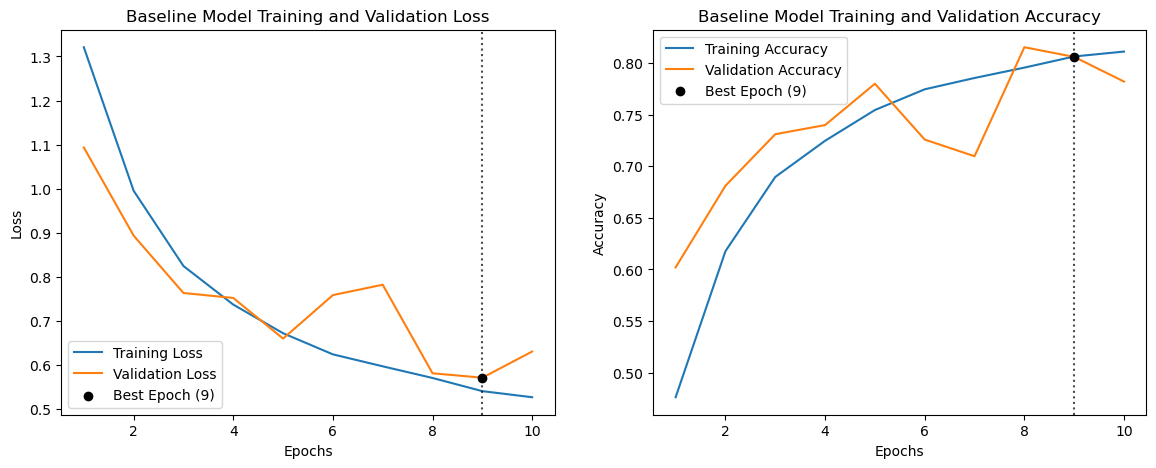

In [28]:
# (i) the training and validation losses and accuracies on the training and validation set through epochs, 

def plot_training_history(history):
    epochs_axis = range(1, len(history.epoch) + 1)  # Epochs + 1 for spacing
    
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch]
    best_val_acc = history.history['val_accuracy'][best_epoch]

    # Plot Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_axis, history.history['loss'], label='Training Loss')
    plt.plot(epochs_axis, history.history['val_loss'], label='Validation Loss')
    # Add one because of the indexing, python starts at 0 and axis at 1
    plt.scatter(best_epoch + 1, best_val_loss, color='black', label=f'Best Epoch ({best_epoch + 1})', zorder=3)
    plt.axvline(best_epoch + 1, color='black', linestyle='dotted', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.legend()
    
  

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_axis, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_axis, history.history['val_accuracy'], label='Validation Accuracy')
    plt.scatter(best_epoch + 1, best_val_acc, color='black', label=f'Best Epoch ({best_epoch + 1})', zorder=3)
    plt.axvline(best_epoch + 1, color='black', linestyle='dotted', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

# Call the function with your model's history
plot_training_history(history)

In [30]:
# (ii) the Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets.
def collect_predictions(model, dataset):
    """
    Collect model predictions and true labels from a given dataset.
    
    Returns:
        true_labels_onehot: Array of one-hot encoded true labels.
        true_labels: Array of integer true labels.
        predicted_probabilities: Array of model output probabilities.
        predicted_classes: Array of predicted class labels.
    """
    true_labels_onehot_list = []        # FOR ROC 
    true_labels_list = []               # For Confusion Matrix & Classification Metrics (discrete labels)
    predicted_probabilities_list = []   # For ROC (softmax probabilities)
    predicted_classes_list = []         # For Confusion Matrix & Classification Metrics (discrete labels)
    
    for i in range(len(dataset)):
        image, label = dataset[i]
        true_labels_onehot_list.append(label)
        true_labels_list.append(np.argmax(label, axis=1))  # Axis = 1, over the images 
        
        # Obtain model predictions (probabilities) for the current batch
        probabilities_batch = model.predict(image)
        predicted_probabilities_list.append(probabilities_batch)
        predicted_classes_list.append(np.argmax(probabilities_batch, axis=1))
    
    # Collect the predictions and labels in a numpy array.
    true_labels_onehot = np.concatenate(true_labels_onehot_list, axis=0)
    true_labels = np.concatenate(true_labels_list, axis=0)
    predicted_probabilities = np.concatenate(predicted_probabilities_list, axis=0)
    predicted_classes = np.concatenate(predicted_classes_list, axis=0)
    
    return true_labels_onehot, true_labels, predicted_probabilities, predicted_classes

# Collect predictions for the validation set
true_labels_val_onehot, true_labels_val, predicted_probabilities_val, predicted_classes_val = collect_predictions(model, val_data_aug)

# Collect predictions for the test set
true_labels_test_onehot, true_labels_test, predicted_probabilities_test, predicted_classes_test = collect_predictions(model, test_data_aug)  

C:\Users\lvers\AppData\Local\Temp\ipykernel_13292\3347811448.py:28: UserWarning: image is size 1 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = estimate_sigma(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

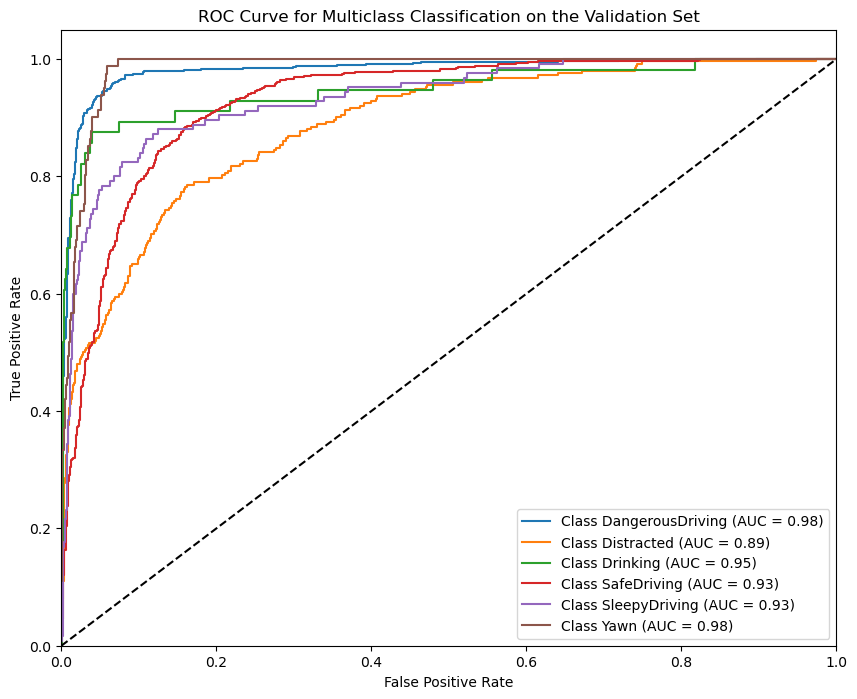

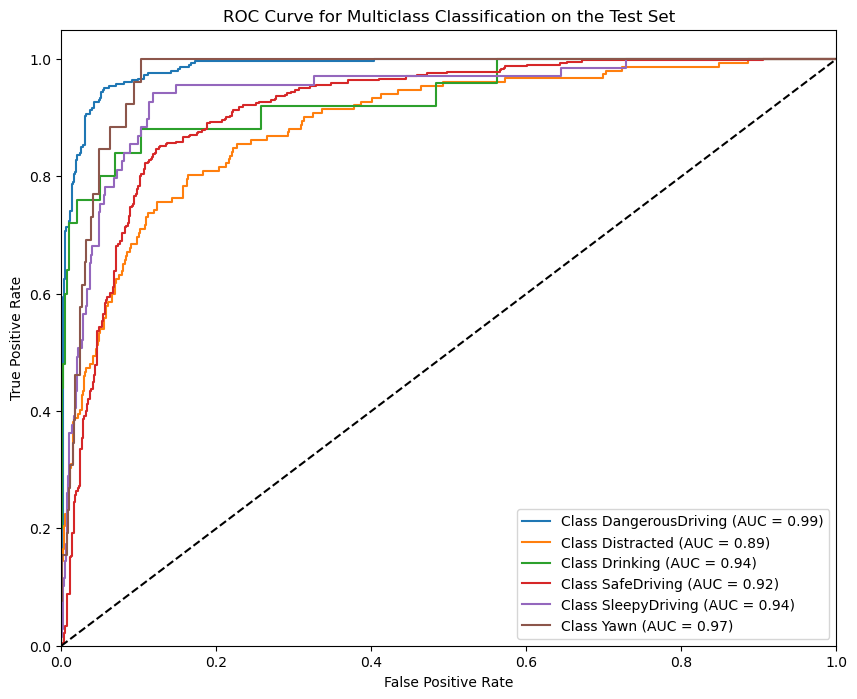

In [31]:
def plot_multiclass_roc(true_labels_onehot, predicted_probabilities, class_names, dataset_name='Dataset'):
    """
    Computes and plots the ROC curves and AUC scores for each class for the multiclass image classification

    Parameters:
        true_labels_onehot (np.array): One-hot encoded true labels with shape (n_samples, n_classes).
        predicted_probabilities (np.array): Predicted probabilities with shape (n_samples, n_classes).
        class_names (list): List of class names (strings).
        dataset_name (str): Name of the dataset (e.g., 'Validation Set' or 'Test Set') for the plot title.
    """
    # Initialize dictionaries to store  metrics for each class
    fpr = {}          # False Positive Rate
    tpr = {}          # True Positive Rate
    auc_scores = {}   # Area Under the Curve Scores

    # Compute ROC curve and AUC for each class
    for class_index in range(len(class_names)): # [0,1,2,3,4,5]
        fpr[class_index], tpr[class_index], _ = roc_curve(
            true_labels_onehot[:, class_index],   # Select all images with a given the given class index
            predicted_probabilities[:, class_index]  # Collect the probabilities attached to it
        )
        auc_scores[class_index] = auc(fpr[class_index], tpr[class_index])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for class_index in range(len(class_names)): # Loop over each class to plot a line 
        plt.plot(
            fpr[class_index],
            tpr[class_index],
            label=f'Class {class_names[class_index]} (AUC = {auc_scores[class_index]:.2f})'
        )
    # Plot the diagonal line representing random classifier performance
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multiclass Classification on the {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
# For the validation set:
plot_multiclass_roc(true_labels_val_onehot, predicted_probabilities_val, class_names, dataset_name='Validation Set')

# For the test set:
plot_multiclass_roc(true_labels_test_onehot, predicted_probabilities_test, class_names, dataset_name='Test Set')

<Figure size 1000x800 with 0 Axes>

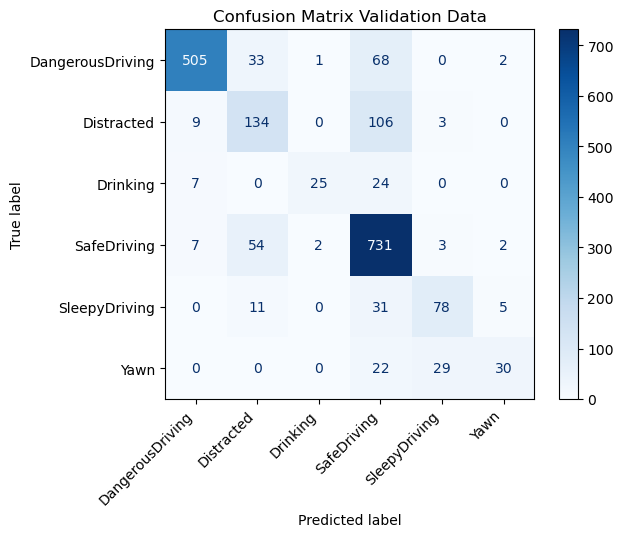

<Figure size 1000x800 with 0 Axes>

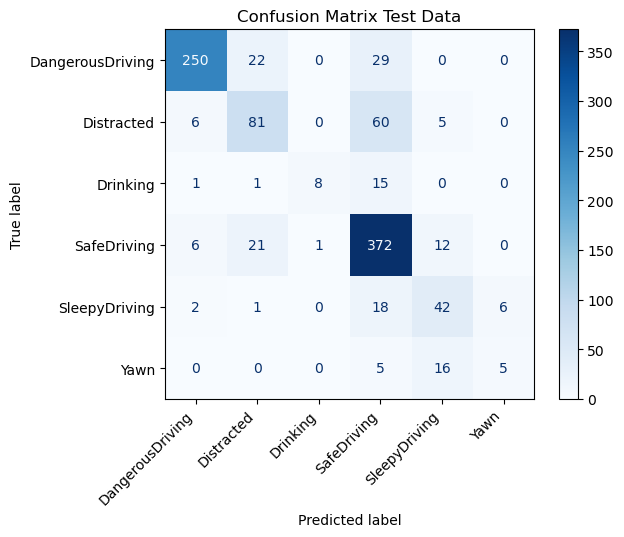

In [32]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names, dataset_name):
    """
    Plots a confusion matrix given the true and predicted labels.
    
    Parameters:
        true_labels (np.array): The true labels. If one-hot encoded, they will be converted to discrete labels.
        predicted_labels (np.array): The predicted labels (discrete).
        class_names (list): List of class names for display.
        dataset_name (str):  Name of the dataset (e.g., 'Validation Set' or 'Test Set') for the plot title.
    """
    # Compute confusion matrix and create a display object
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix {dataset_name}")
    plt.xticks(rotation=45, ha="right")
    plt.show()


# CM Validation Data:
plot_confusion_matrix(true_labels_val, predicted_classes_val, class_names, dataset_name='Validation Data')

# CM Test Data:
plot_confusion_matrix(true_labels_test, predicted_classes_test, class_names, dataset_name='Test Data')


In [33]:
def compute_and_print_metrics(true_labels, predicted_labels, dataset_name="Dataset"):
    """
    Computes and prints the weighted precision, accuracy, F1 score, and recall.
    
    Parameters:
        true_labels (np.array): True labels, either one-hot encoded or discrete.
        predicted_labels (np.array): Predicted class labels (discrete).
        dataset_name (str): Name of the dataset (e.g., "Validation Set", "Test Set").
    """
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    # Print the results in a formatted manner
    print("\n=====================================")
    print(f" Performance Metrics for {dataset_name}")
    print("=====================================")
    print(f"Precision  : {precision:.4f}")
    print(f"Accuracy   : {accuracy:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"Recall     : {recall:.4f}")
    print("=====================================\n")


# Metrics for the Validation Set:
compute_and_print_metrics(true_labels_val, predicted_classes_val, dataset_name="Validation Set")

# Metrics for the Test Set:
compute_and_print_metrics(true_labels_test, predicted_classes_test, dataset_name="Test Set")


 Performance Metrics for Validation Set
Precision  : 0.7916
Accuracy   : 0.7820
F1 Score   : 0.7764
Recall     : 0.7820


 Performance Metrics for Test Set
Precision  : 0.7731
Accuracy   : 0.7695
F1 Score   : 0.7614
Recall     : 0.7695



# Hyperparameter Tuning:
 (see the doc for explanations) - https://docs.google.com/document/d/14im4vWg0ckz-oTqlRXuSiOc_V5o_qI3vI53k6ajmwgI/edit?usp=sharing 

### Random search

In [47]:
def create_model(hp):
    model = models.Sequential()

    # First Layer
    model.add(layers.Conv2D(32, (hp.Int('kernel_size_1', 3, 7, step=2), hp.Int('kernel_size_1', 3, 7, step=2)), 
                            activation=hp.Choice('activation', ['relu', 'elu', 'swish', 'tanh']),
                            input_shape=(72, 128, 1)))  
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Layer
    model.add(layers.Conv2D(64, (hp.Int('kernel_size_2', 3, 7, step=2), hp.Int('kernel_size_2', 3, 7, step=2)),
                            activation=hp.Choice('activation', ['relu', 'elu', 'swish', 'tanh'])))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Layer
    model.add(layers.Conv2D(128, (hp.Int('kernel_size_3', 3, 7, step=2), hp.Int('kernel_size_3', 3, 7, step=2)),
                            activation=hp.Choice('activation', ['relu', 'elu', 'swish', 'tanh'])))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense Layer
    hp_units = hp.Int('dense_units', min_value=32, max_value=1024, step=32)
    model.add(layers.Dense(hp_units, activation=hp.Choice('activation', ['relu', 'elu', 'swish', 'tanh'])))

    # Dropout
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    # Output layer
    model.add(layers.Dense(6, activation='softmax'))

    # Choosing Optimizer and Learning rate
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.01, 0.1])

    if hp_optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer_instance,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


### Random Search (Matthijs)

In week 4, we have discussed the use of Batch Normalization, which could we interesting as well to try and use for our models. Together in the practical the discussion was, L1, L2 regulazatino don't do it. In practice everyone uses dropout which you already did! 

def build_hp_classification_model(hp):
    
    input_shape = (img_height, img_width, 1)
    
    model = models.Sequential()
    
    # ----- Convolutional Block 1 -----
    conv1_filters = hp.Int('conv1_filters', min_value=16, max_value=64, step=16)
    conv1_kernel = hp.Choice('conv1_kernel', values=[3, 5])
    model.add(layers.Conv2D(conv1_filters, (conv1_kernel, conv1_kernel), 
                            activation='relu', 
                            input_shape=input_shape,
                            padding='same',
                            kernel_regularizer=regularizers.l2(1e-4),
                            name='conv1'))
    # Optional Batch Normalization for Block 1
    if hp.Boolean('use_bn1'):
        model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    
    # ----- Convolutional Block 2 -----
    conv2_filters = hp.Int('conv2_filters', min_value=16, max_value=128, step=16)
    conv2_kernel = hp.Choice('conv2_kernel', values=[3, 5])
    model.add(layers.Conv2D(conv2_filters, (conv2_kernel, conv2_kernel),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(1e-4),
                            name='conv2'))
    # Optional Batch Normalization for Block 2
    if hp.Boolean('use_bn2'):
        model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    
    # ----- Optional Convolutional Block 3 -----
    if hp.Boolean('add_conv3'):
        conv3_filters = hp.Int('conv3_filters', min_value=16, max_value=128, step=16)
        conv3_kernel = hp.Choice('conv3_kernel', values=[3, 5])
        model.add(layers.Conv2D(conv3_filters, (conv3_kernel, conv3_kernel),
                                activation='relu',
                                padding='same',
                                kernel_regularizer=regularizers.l2(1e-4),
                                name='conv3'))
        # Optional Batch Normalization for Block 3
        if hp.Boolean('use_bn3'):
            model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    
    # ----- Flattening Layer -----
    model.add(layers.Flatten(name='flatten'))
    
    # ----- Fully Connected Dense Layer -----
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(layers.Dense(dense_units, activation='relu',
                           kernel_regularizer=regularizers.l2(1e-4),
                           name='dense1'))
    
    # ----- Dropout for Regularization -----
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate, name='dropout'))
    
    # ----- Output Layer -----
    model.add(layers.Dense(6, activation='softmax', name='output'))
    
    # ----- Optimizer & Compilation -----
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    optimizer = Adam(learning_rate=learning_rate) if optimizer_choice == 'adam' else RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model


In [49]:
random_tuner = kt.RandomSearch(create_model, objective='val_accuracy', max_trials= 30, executions_per_trial=1,  directory='./',project_name='RandomSearch2')

# Running the search
random_tuner.search(train_data, epochs=10, batch_size=32, validation_data=val_data)

Trial 2 Complete [00h 00m 42s]
val_accuracy: 0.6875

Best val_accuracy So Far: 0.6875
Total elapsed time: 00h 01m 36s


In [50]:
best_parameters = random_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best kernel size for 1st layer: {best_parameters.get('kernel_size_1')}")
print(f"Best kernel size for 2nd layer: {best_parameters.get('kernel_size_2')}")
print(f"Best kernel size for 3rd layer: {best_parameters.get('kernel_size_3')}")
print(f"Best activation function: {best_parameters.get('activation')}")
print(f"Best nr of units in dense layer: {best_parameters.get('dense_units')}")
print(f"Best learning rate: {best_parameters.get('learning_rate')}")
print(f"Best dropout rate: {round(best_parameters.get('dropout_rate'), 2)}")
print(f"Best optimizer: {best_parameters.get('optimizer')}")

Best kernel size for 1st layer: 7
Best kernel size for 2nd layer: 7
Best kernel size for 3rd layer: 3
Best activation function: relu
Best nr of units in dense layer: 832
Best learning rate: 0.001
Best dropout rate: 0.1
Best optimizer: rmsprop


### Running the best model

In [51]:
# Define the model
def best_model(best_parameters, classes = 6):
    model = models.Sequential()

    # First Conv Layer
    model.add(layers.Conv2D(32, (best_parameters.get('kernel_size_1'), best_parameters.get('kernel_size_1')), activation=best_parameters.get('activation'), input_shape=(72, 128, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Conv Layer
    try:
        model.add(layers.Conv2D(64, (best_parameters.get('kernel_size_2'), best_parameters.get('kernel_size_2')), activation=best_parameters.get('activation')))
        model.add(layers.MaxPooling2D((2, 2)))
    except:
        pass

    # Third Conv Layer
    try:
        model.add(layers.Conv2D(128, (best_parameters.get('kernel_size_3'), best_parameters.get('kernel_size_3')), activation=best_parameters.get('activation')))
        model.add(layers.MaxPooling2D((2, 2)))
    except:
        pass

    model.add(layers.Flatten())

    # Dense Layer
    model.add(layers.Dense(best_parameters.get('dense_units'), activation=best_parameters.get('activation')))

    # Dropout Layer
    model.add(layers.Dropout(best_parameters.get('dropout_rate')))

    # Output Layer
    model.add(layers.Dense(classes, activation='softmax'))

    # Optimizer
    if best_parameters.get('optimizer') == 'adam':
        optimizer = optimizers.Adam(learning_rate=best_parameters.get('learning_rate'))
    elif best_parameters.get('optimizer') == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=best_parameters.get('learning_rate'))
    elif best_parameters.get('optimizer') == 'sgd':
        optimizer = optimizers.SGD(learning_rate=best_parameters.get('learning_rate'))

    # Compile Model
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Instantiate the model
model = best_model(best_parameters)

# Summary
model.summary()

# Train the model
history = model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 66, 122, 32)    │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 33, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 55, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 832)            │     6,390,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         4,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,571,462 (25.07 MB)

 Trainable params: 6,571,462 (25.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.3183 - loss: 3.3445 - val_accuracy: 0.3125 - val_loss: 1.3850
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.4422 - loss: 1.4506 - val_accuracy: 0.4583 - val_loss: 1.4075
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.4202 - loss: 1.4315 - val_accuracy: 0.4688 - val_loss: 1.4518
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.4038 - loss: 1.4340 - val_accuracy: 0.5208 - val_loss: 1.3720
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4745 - loss: 1.3721 - val_accuracy: 0.5938 - val_loss: 1.2247
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.4803 - loss: 1.3128 - val_accuracy: 0.6146 - val_loss: 1.1368
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.4992 - loss: 1.2763 - val_accuracy: 0.5938 - val_loss: 1.0808
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.5940 - loss: 1.1266 - val_accuracy: 0.

### Predictions and accuracy, recall, F1, classification report - VALIDATION SET

In [52]:
# Metrics for the Validation Set:
collect_predictions(model, val_data)
compute_and_print_metrics(true_labels_val, predicted_classes_val, dataset_name="Hypertuned Model on Validation Set")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

 Performance Metrics for Hypertuned Model on Validation Set
Precision  : 0.4940
Accuracy   : 0.6146
F1 Score   : 0.5405
Recall     : 0.6146



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Predictions and accuracy, recall, F1, classification report - TEST SET

In [59]:
# Metrics for the Test Set:
collect_predictions(model, test_data)
compute_and_print_metrics(true_labels_val, predicted_classes_val, dataset_name="Hypertuned Model on Test Set")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

 Performance Metrics for Hypertuned Model on Test Set
Precision  : 0.4940
Accuracy   : 0.6146
F1 Score   : 0.5405
Recall     : 0.6146



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ROC curve and Confusion Matrix

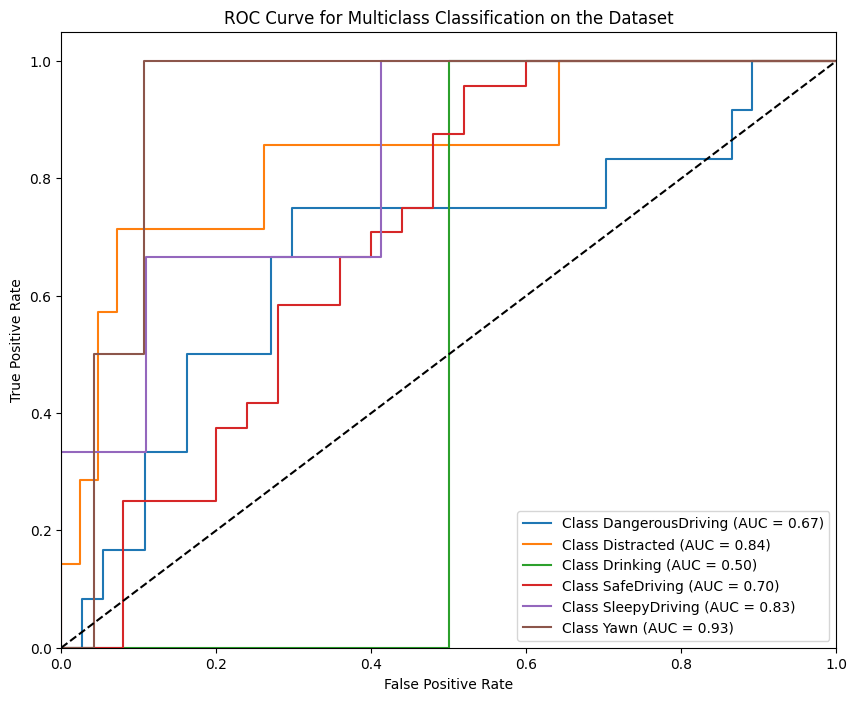

In [58]:
# For the test set:
plot_multiclass_roc(true_labels_test_onehot, predicted_probabilities_test, class_names)

In [55]:
# Classification Report
print("Classification Report:\n", classification_report(true_labels_test, predicted_classes_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         1
           3       0.61      0.96      0.74        24
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2

    accuracy                           0.57        49
   macro avg       0.18      0.23      0.20        49
weighted avg       0.41      0.57      0.47        49



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

<Figure size 1000x800 with 0 Axes>

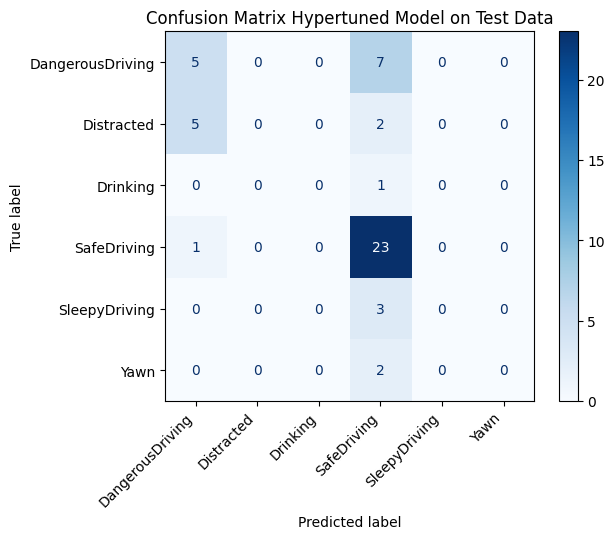

In [57]:
# CM Validation Data:
plot_confusion_matrix(true_labels_test, predicted_classes_test, class_names, dataset_name='Hypertuned Model on Test Data')
